# Using enterprise and extensions to analyze data of a single pulsar.

In this notebook you will learn:
* How to use `enterprise` with its `extensions` to interact with NANOGrav data,
* How to check whether a single pulsar prefers a common red process,
* How to compute Bayes factors using the Savage-Dickey approximation.

# Load packages and modules

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg as sl

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

# enterprise_extensions imports:
import enterprise_extensions
from enterprise_extensions import models, model_utils, hypermodel

import sys
sys.path.append("..")
from settings import fd_bins

## Get par, tim, and noise files

In [2]:
psrlist = None # define a list of pulsar name strings that can be used to filter.
# set the data directory
datadir = '../data'
if not os.path.isdir(datadir):
    datadir = '../../data'
print(datadir)

../../data


In [3]:
# Get J1713 only
psrname = 'J1713'
parfiles = sorted(glob.glob(datadir + '/par/' + psrname + '*par'))
timfiles = sorted(glob.glob(datadir + '/tim/' + psrname + '*tim'))

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile...
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]
print(parfiles)
print(timfiles)

['../../data/par/J1713+0747_NANOGrav_12yv3.gls.t2.par']
['../../data/tim/J1713+0747_NANOGrav_12yv3.tim']


### Load pulsars

In [4]:
psrs = []
ephemeris = 'DE438'
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t, ephem=ephemeris)
    psrs.append(psr)

### Get noise dictionary

In [5]:
## Get parameter noise dictionary
noise_ng12 = datadir + '/channelized_12p5yr_v3_full_noisedict.json'

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

### Create model with common red process

In [6]:
# this sets up the pta model (everything we did above) all in one cell
# model 2a includes:
#   fixed white noise parameters based on noisedict
#   common red noise signal (no correlation function) with 5 sampling frequencies (default 30 freqs)
pta = models.model_2a(psrs,
                      psd='powerlaw',
                      noisedict=params,
                      n_gwbfreqs=5,  # modify the number of common red noise frequencies here
                      gamma_common=13/3)  # remove this line for a varying spectral index

# Note that the number of frequency components here is changed to line up with the search in the full PTA search

In [7]:
# Setup an instance of a HyperModel.
# This doesn't mean we are doing model selection (yet!), but the 
# hypermodel module gives access to some nifty sampling schemes.
super_model = hypermodel.HyperModel({0: pta})

### Sample with PTMCMCSampler
* Chains have been included to save time sampling

In [8]:
outDir = '../../chains/sngl_gwb_ext'
sampler = super_model.setup_sampler(resume=False, outdir=outDir, sample_nmodel=True)

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...

Adding nmodel uniform distribution draws...



/Users/aaron/opt/anaconda3/envs/enterprise/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [9]:
# sampler for N steps (this should take about 100 mins.)
N = int(1e6)  # normally this would be 5e6, but this saves time
x0 = super_model.initial_sample()
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

In [10]:
# Uncomment this one to load the chain if you have sampled with PTMCMCSampler:
# chain = np.loadtxt(os.path.join(outDir, 'chain_1.txt'))

# This will load the chain that we have provided:
chain = np.load(os.path.join(outDir, 'chain_1.npz'))['arr_0']
burn = int(0.25 * chain.shape[0])  # remove burn in segment of sampling

In [11]:
ind = list(pta.param_names).index('gw_log10_A')

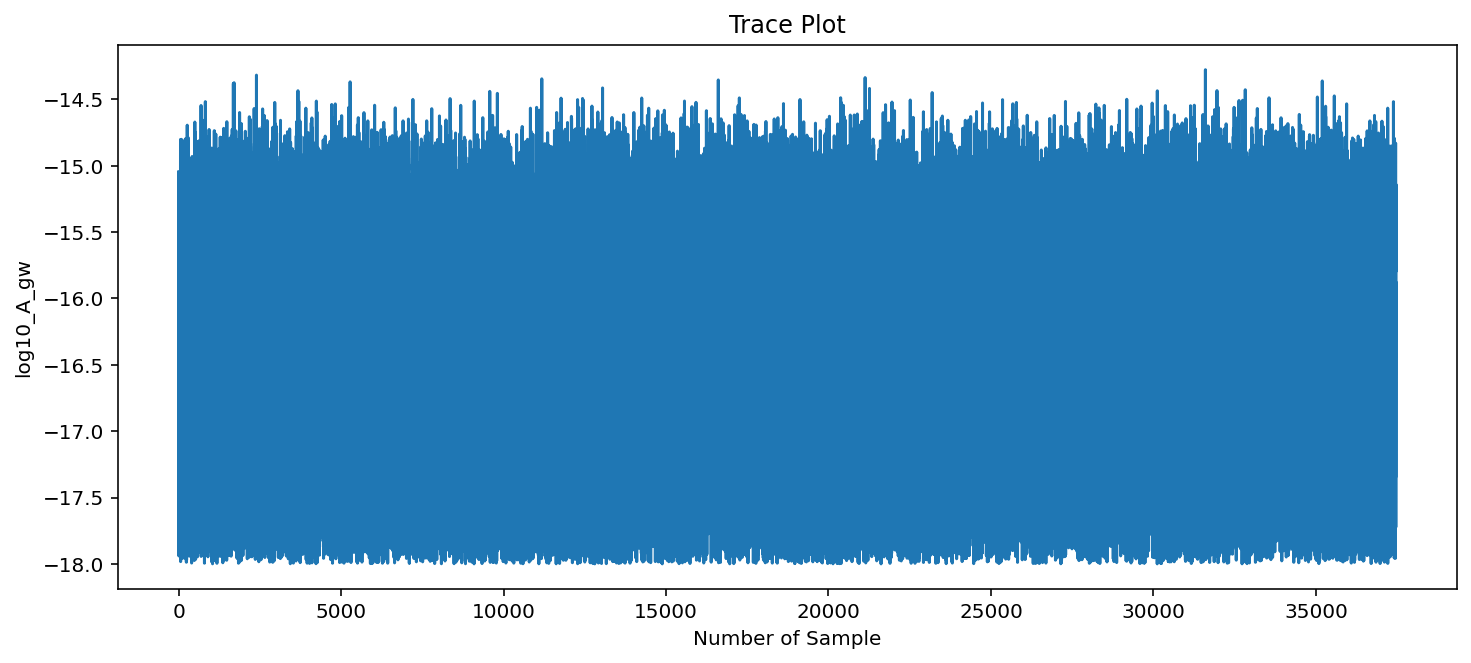

In [19]:
# Make trace-plot to diagnose sampling
plt.figure(figsize=(12, 5))
plt.plot(chain[burn:, ind])
plt.xlabel('Number of Sample')
plt.ylabel('log10_A_gw')
plt.title('Trace Plot')
plt.show()

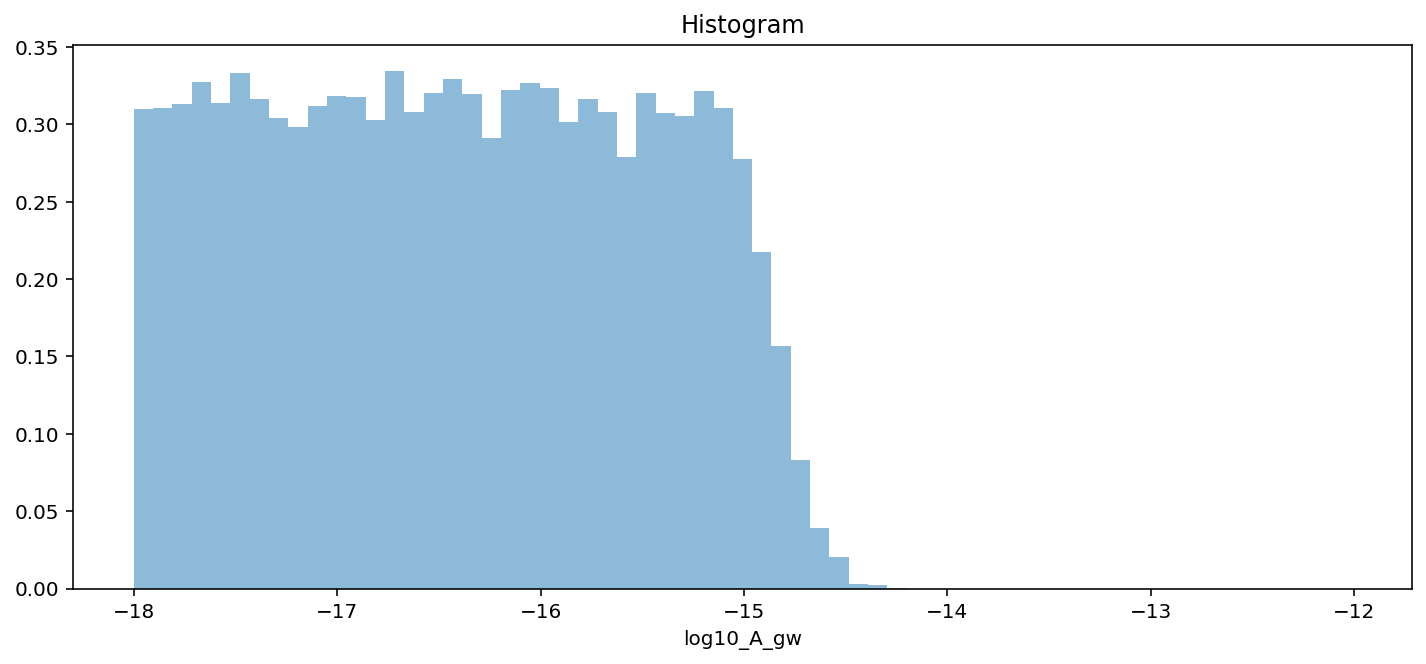

In [24]:
# Plot a histogram of the marginalized posterior distribution
bins = fd_bins(chain[burn:, ind], logAmin=-18, logAmax=-12)  # let FD rule decide bins (in ../settings.py)
plt.figure(figsize=(12, 5))
plt.title('Histogram')
plt.hist(chain[burn:,ind], bins=bins, histtype='stepfilled', 
         lw=2, color='C0', alpha=0.5, density=True)
plt.xlabel('log10_A_gw')
plt.show()

## Savage Dickey Approximation Bayes factor
* As long as the posterior has a tail, we can compare that tail with the prior to compute a quick approximate Bayes factor
* To do this, we take a function from `enterprise_extensions` which will compare the prior and posterior as the parameter goes to zero

In [25]:
from enterprise_extensions.model_utils import bayes_fac

In [29]:
bf = bayes_fac(chain[burn:,ind], ntol=0, logAmin=-18, logAmax=-12)
print(bf)

(0.5221296546523881, 0.01296824450558217)


In [48]:
log10_bf = np.log10(bf[0])
print(log10_bf)

-0.28222164008528683


## Remarks
* J1713 doesn't currently support a common red process in the data.
* Investigations into why this is the case are ongoing.